<a href="https://colab.research.google.com/github/cactus1386/AI-WebScrapper/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import Libraries

In [19]:
! pip install ultralytics easyocr hezar insightface onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00


In [59]:
import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
from google.colab.patches import cv2_imshow
import os
import pandas as pd
import re
from hezar.models import Model
from insightface.app import FaceAnalysis

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read kibord dataset

In [4]:
import gdown
import zipfile
import os

In [5]:
file_id = "1EP7JhNFoLtlmJCabhrpTYOkMJ2c_OyMM"
dataset_zip_path = "/content/dataset.zip"
extract_path = "/content/dataset"

In [6]:
gdown.download(f"https://drive.google.com/uc?id={file_id}", dataset_zip_path, quiet=False)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset downloaded and extracted successfully!")


Downloading...
From (original): https://drive.google.com/uc?id=1EP7JhNFoLtlmJCabhrpTYOkMJ2c_OyMM
From (redirected): https://drive.google.com/uc?id=1EP7JhNFoLtlmJCabhrpTYOkMJ2c_OyMM&confirm=t&uuid=6f05fa74-3d7e-462a-99b3-fd8490a30692
To: /content/dataset.zip
100%|██████████| 539M/539M [00:10<00:00, 52.7MB/s]


✅ Dataset downloaded and extracted successfully!


In [7]:
print("Sample files:", os.listdir(extract_path)[:5])

Sample files: ['2832.PNG', '1443.jpg', '650.PNG', '5.PNG', '1601.jpg']


# Set model and path

In [65]:
detector = FaceAnalysis(name='buffalo_l')
detector.prepare(ctx_id=0, det_size=(640, 640))
objects_model = YOLO('/content/drive/MyDrive/models/TextDetection.pt') # set yolo model for object detection
card_model = YOLO('/content/drive/MyDrive//models/CardDetection.pt') # set yolo model for card detection
ocr = easyocr.Reader(['fa']) # set persian ocr reader
hezar_ocr = Model.load("hezarai/crnn-fa-printed-96-long") # set hezar ocr model

/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


# Rotation Code

In [66]:
def rotation(path):
    image = cv2.imread(path) # set image
    results = card_model(image) # run card yolo model for image

    if len(results[0].boxes) == 0: # if cant recognize card
        print("No card detected!")
        return None

    # set 4 corner location
    x1, y1, x2, y2 = map(int, results[0].boxes[0].xyxy[0])
    cropped_card = image[y1:y2, x1:x2]

    # detect face in the cropped card
    faces = detector.get(cropped_card)

    # check for faces
    if faces:
        x1, y1, x2, y2 = map(int, faces[0]['bbox'])  # Get face bounding box
        w, h = x2 - x1, y2 - y1
        face_center = (x1 + w // 2, y1 + h // 2)  # Face center
        card_center = (cropped_card.shape[1] // 2, cropped_card.shape[0] // 2)  # Card center

        # calculate rotation angle
        angle = np.arctan2(face_center[1] - card_center[1], face_center[0] - card_center[0]) * (180 / np.pi) + 180
        rotation_matrix = cv2.getRotationMatrix2D(card_center, angle, 1.0)
        rotated = cv2.warpAffine(cropped_card, rotation_matrix, (cropped_card.shape[1], cropped_card.shape[0]))

        return rotated  # return image

    return cropped_card  # if cant find face


# Use other model for text detection (Hezar)

In [67]:
def process_img(img):
    data = {}
    results = objects_model(img) # set part of object detection yolo model

    # dict for each box conf
    box_confidences = {}

    for result in results:
        boxes = result.boxes
        for box in boxes:
            xyxy = box.xyxy[0]
            x1, y1, x2, y2 = map(int, xyxy.tolist()) # set corner locations
            label = result.names[int(box.cls)] # set label
            conf = float(box.conf)  # set conf

            cropped_img = img[max(0, y1-3):y2+3, max(0, x1-3):x2+3] # cropped image location (with more nums for better conf)
            cv2_imshow(cropped_img)

            ocr_result = hezar_ocr.predict(cropped_img)  # read text with ocr

            if ocr_result:  # check if OCR returned results
                text_list = []
                for item in ocr_result:
                    text_list.append(item['text'])
                text = " ".join(text_list)  # retrun text
            else:
                text = "" # return empty str

            # best conf text (if have more than one)
            if label in box_confidences:
                if conf > box_confidences[label][1]:
                    box_confidences[label] = (text, conf)
            else:
                box_confidences[label] = (text, conf)

    # print label, text and conf
    for label, (text, conf) in box_confidences.items():
        print(f"Label: {label}, Text: {text}, Confidence: {conf}")
        data[label] = text.strip()

    return data

# Call function and use it

In [68]:
def detect(folder):
    detected = [] # set empty list
    for img in os.listdir(folder):
      # get images from folder and set csv columns
        if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.heic')):
            img_path = os.path.join(folder, img)
            data = {'image_id': img.split('.')[0], 'national_id': '', 'first_name': '', 'last_name': '',
                    'birth_year': '', 'birth_month': '', 'birth_day': '', 'father_name': '',
                    'expiry_year': '', 'expiry_month': '', 'expiry_day': ''}

            # rotation and crop card
            card = rotation(img_path)
            if card is None:
                continue

            # extract data from cropped image
            extracted_data = process_img(card)


            # set data in dict and in csv
            for key, value in extracted_data.items():
                value = re.sub(r'\s+', ' ', value).strip() # delete space from value (we have no white space in texts)
                if key == 'Expire': # set expiry date value in dict
                    try:
                        y, m, d = value.split('/') # splite to year, month and day
                        data['expiry_year'], data['expiry_month'], data['expiry_day'] = y, m, d # set expiry day, month and year
                    except ValueError:# if cant detect "/" well and get error
                        print(f"Error splitting Expire: {value}")
                elif key == 'Birth': # set birth date value in dict
                    try:
                        y, m, d = value.split('/') # splite to year, month and day
                        data['birth_year'], data['birth_month'], data['birth_day'] = y, m, d # set birth day, month and year
                    except ValueError: # if cant detect "/" well and get error
                        print(f"Error splitting Birth: {value}")
                elif key == 'National': # set national id value in dict
                    data['national_id'] = value
                elif key == 'Name': # set name value in dict
                    data['first_name'] = value
                elif key == 'LastName': # set last name value in dict
                    data['last_name'] = value
                elif key == 'FatherName': # set father name value in dict
                    data['father_name'] = value

            detected.append(data)

    pd.DataFrame(detected).to_csv('image_phase2.csv', index=False, encoding='utf-8')
    return detected


0: 640x288 1 Card, 11.1ms
Speed: 3.9ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



0: 640x448 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


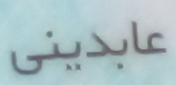

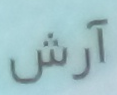

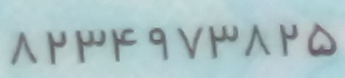

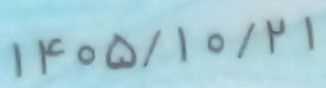

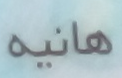

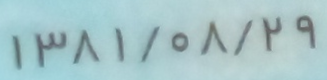

Label: LastName, Text: عابدینی, Confidence: 0.8668094873428345
Label: FatherName, Text: آرش, Confidence: 0.8604722619056702
Label: National, Text: ۸۲۳۴۹۷۳۸۲۵, Confidence: 0.8307475447654724
Label: Expire, Text: ۱۴۰۵/۱۰/۲۱, Confidence: 0.8263546824455261
Label: Name, Text: هانیه, Confidence: 0.8160519003868103
Label: Birth, Text: ۱۳۸۱/۰۸/۲۹, Confidence: 0.780507504940033

0: 416x640 1 Card, 14.6ms
Speed: 3.4ms preprocess, 14.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 14.7ms
Speed: 3.5ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)


Label: National, Text: ۹۴۹۰۵۴۹۰۰۸, Confidence: 0.885198175907135
Label: Birth, Text: ۱۳۶۷/۱۱/۲۳, Confidence: 0.8712563514709473
Label: Expire, Text: ۱۴۱۰/۰۳/۲۰, Confidence: 0.8705952763557434
Label: LastName, Text: کرمی, Confidence: 0.854110836982727
Label: Name, Text: اکبر, Confidence: 0.8535252809524536
Label: FatherName, Text: تیرداد, Confidence: 0.8264328837394714

0: 288x640 1 Card, 11.9ms
Speed: 3.5ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 14.9ms
Speed: 4.0ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


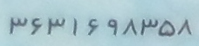

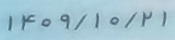

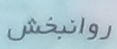

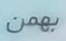

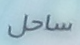

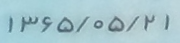

Label: National, Text: ۳۶۳۱۶۹۸۳۵۸, Confidence: 0.8449430465698242
Label: Expire, Text: ۱۴۰۹/۱۰/۲۱, Confidence: 0.8340436816215515
Label: LastName, Text: روانیخش, Confidence: 0.813241720199585
Label: FatherName, Text: بهمن, Confidence: 0.8012444376945496
Label: Name, Text: ساحل, Confidence: 0.7840943932533264
Label: Birth, Text: ۱۳۶۵/۰۵/۲۱, Confidence: 0.7755294442176819

0: 416x640 1 Card, 13.5ms
Speed: 3.7ms preprocess, 13.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)

0: 256x640 2 Births, 3 Expires, 1 FatherName, 1 LastName, 1 Name, 1 National, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 640)


Label: National, Text: ۲۴۷۰۹۴۹۷۱۱, Confidence: 0.8239166140556335
Label: LastName, Text: هارابی, Confidence: 0.8039987087249756
Label: Name, Text: ترانه, Confidence: 0.7754095792770386
Label: Expire, Text: ۱۴۰۵/۰۶/۲۶, Confidence: 0.7379994988441467
Label: FatherName, Text: آذرباد, Confidence: 0.7238460183143616
Label: Birth, Text: ۱۳۷۰/۱۰/۱۳, Confidence: 0.6508969068527222

0: 288x640 1 Card, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 13.9ms
Speed: 2.8ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


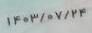

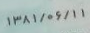

Label: Expire, Text: ۱۴۰۳/۰۷/۲۴, Confidence: 0.8392114043235779
Label: Birth, Text: ۱۳۸۱/۰۶/۱۱, Confidence: 0.8179891705513
Label: National, Text: ۴۷۷۱۵۵۴۰۵۷, Confidence: 0.7983295917510986
Label: LastName, Text: الماسی, Confidence: 0.7897236347198486
Label: Name, Text: گمان, Confidence: 0.7791969776153564
Label: FatherName, Text: مجمد, Confidence: 0.7223954796791077

0: 416x640 1 Card, 13.6ms
Speed: 3.7ms preprocess, 13.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 640x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 22.6ms
Speed: 4.2ms preprocess, 22.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Label: LastName, Text: بحباری, Confidence: 0.8730766773223877
Label: Name, Text: مصطفی, Confidence: 0.8452092409133911
Label: National, Text: ۵۹۵۹۰۶۶۳۸۹, Confidence: 0.8407571911811829
Label: Expire, Text: ۱۴۰۷/۰۷/۱۷, Confidence: 0.8268125653266907
Label: Birth, Text: ۱۳۸۲/۰۶/۰۹, Confidence: 0.8162897229194641
Label: FatherName, Text: عحصدعلی, Confidence: 0.7932020425796509


[{'image_id': '46',
  'national_id': '۸۲۳۴۹۷۳۸۲۵',
  'first_name': 'هانیه',
  'last_name': 'عابدینی',
  'birth_year': '۱۳۸۱',
  'birth_month': '۰۸',
  'birth_day': '۲۹',
  'father_name': 'آرش',
  'expiry_year': '۱۴۰۵',
  'expiry_month': '۱۰',
  'expiry_day': '۲۱'},
 {'image_id': '105',
  'national_id': '۹۴۹۰۵۴۹۰۰۸',
  'first_name': 'اکبر',
  'last_name': 'کرمی',
  'birth_year': '۱۳۶۷',
  'birth_month': '۱۱',
  'birth_day': '۲۳',
  'father_name': 'تیرداد',
  'expiry_year': '۱۴۱۰',
  'expiry_month': '۰۳',
  'expiry_day': '۲۰'},
 {'image_id': '98',
  'national_id': '۳۶۳۱۶۹۸۳۵۸',
  'first_name': 'ساحل',
  'last_name': 'روانیخش',
  'birth_year': '۱۳۶۵',
  'birth_month': '۰۵',
  'birth_day': '۲۱',
  'father_name': 'بهمن',
  'expiry_year': '۱۴۰۹',
  'expiry_month': '۱۰',
  'expiry_day': '۲۱'},
 {'image_id': '2145',
  'national_id': '۲۴۷۰۹۴۹۷۱۱',
  'first_name': 'ترانه',
  'last_name': 'هارابی',
  'birth_year': '۱۳۷۰',
  'birth_month': '۱۰',
  'birth_day': '۱۳',
  'father_name': 'آذرباد',
  'e

In [69]:
detect('/content/drive/MyDrive/images/')

# Sort csv

In [70]:
df = pd.read_csv('image_phase2.csv')
df = df.sort_values(by='image_id')
df.to_csv("image_phase2.csv", index=False)

In [71]:
df

,image_id,national_id,first_name,last_name,birth_year,birth_month,birth_day,father_name,expiry_year,expiry_month,expiry_day
4,20,۴۷۷۱۵۵۴۰۵۷,گمان,الماسی,۱۳۸۱,۰۶,۱۱,مجمد,۱۴۰۳,۰۷,۲۴
0,46,۸۲۳۴۹۷۳۸۲۵,هانیه,عابدینی,۱۳۸۱,۰۸,۲۹,آرش,۱۴۰۵,۱۰,۲۱
2,98,۳۶۳۱۶۹۸۳۵۸,ساحل,روانیخش,۱۳۶۵,۰۵,۲۱,بهمن,۱۴۰۹,۱۰,۲۱
1,105,۹۴۹۰۵۴۹۰۰۸,اکبر,کرمی,۱۳۶۷,۱۱,۲۳,تیرداد,۱۴۱۰,۰۳,۲۰
5,1591,۵۹۵۹۰۶۶۳۸۹,مصطفی,بحباری,۱۳۸۲,۰۶,۰۹,عحصدعلی,۱۴۰۷,۰۷,۱۷
3,2145,۲۴۷۰۹۴۹۷۱۱,ترانه,هارابی,۱۳۷۰,۱۰,۱۳,آذرباد,۱۴۰۵,۰۶,۲۶
